In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression   
from sklearn.metrics import mean_squared_error, r2_score 

file_path = r'C:\Users\Luca\Documents\Fatesg-IA-2\Big-Data\Raspagem de Dados\data\raw\dataset_crawler-google-places_2025-11-10_12-46-55-562.json'

df = pd.read_json(file_path)
print("Dados brutos carregados com sucesso.")

Dados brutos carregados com sucesso.


In [5]:
df['reviewsCount_log'] = np.log1p(df['reviewsCount'])
print("reviewsCount_log criado e a assimetria tratada.")

dummies = pd.get_dummies(df['categoryName'], prefix='cat')
df = pd.concat([df, dummies], axis=1) 
print(f"{len(dummies.columns)} novas colunas 'cat_' criadas.")

colunas_para_dropar = [
    'title', 'street', 'city', 'state', 'countryCode', 'phone', 'website', 'zip', 'categoryName', 'reviewsCount', 'url'
]

df_final = df.drop(colunas_para_dropar, axis=1, errors='ignore')

print("\nColunas descartadas. O DataFrame está pronto para modelagem.")
print(f"Novo shape do DataFrame: {df_final.shape}")
print(f"Novas colunas para o modelo: {df_final.columns.tolist()}")

reviewsCount_log criado e a assimetria tratada.
8 novas colunas 'cat_' criadas.

Colunas descartadas. O DataFrame está pronto para modelagem.
Novo shape do DataFrame: (50, 10)
Novas colunas para o modelo: ['totalScore', 'reviewsCount_log', 'cat_Empório gourmet', 'cat_Lanchonete', 'cat_Restaurante', 'cat_Restaurante Mineiro', 'cat_Restaurante brasileiro', 'cat_Restaurante fast-food', 'cat_Restaurante italiano', 'cat_Restaurante self-service']


In [6]:
Y = df_final['totalScore']
X = df_final.drop('totalScore', axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"\nDados divididos: {X_train.shape[0]} amostras para Treino e {X_test.shape[0]} para Teste.")

regressor = LinearRegression()

regressor.fit(X_train, Y_train)

print("Modelo de Regressão Linear treinado com sucesso!")


Dados divididos: 40 amostras para Treino e 10 para Teste.
Modelo de Regressão Linear treinado com sucesso!


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, Y_train)

print("\nModelo Random Forest Regressor treinado com sucesso!")

Y_pred_rf = rf_regressor.predict(X_test)

mse_rf = mean_squared_error(Y_test, Y_pred_rf)
r2_rf = r2_score(Y_test, Y_pred_rf)

print("\n=== AVALIAÇÃO DO MODELO RANDOM FOREST ===")
print(f"Erro Quadrático Médio (MSE): {mse_rf:.4f}")
print(f"Coeficiente de Determinação (R2 Score): {r2_rf:.4f}")

print("\n--- Importância das Features (Random Forest) ---")
feature_importances = pd.Series(rf_regressor.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances.head(5))


Modelo Random Forest Regressor treinado com sucesso!

=== AVALIAÇÃO DO MODELO RANDOM FOREST ===
Erro Quadrático Médio (MSE): 0.1467
Coeficiente de Determinação (R2 Score): 0.3146

--- Importância das Features (Random Forest) ---
reviewsCount_log                0.817665
cat_Restaurante                 0.052898
cat_Lanchonete                  0.036345
cat_Restaurante self-service    0.030266
cat_Restaurante brasileiro      0.027223
dtype: float64


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [5, 10, None],      
    'min_samples_split': [2, 5, 10]  
}

print(f"Total de combinações de hiperparâmetros a testar: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split'])}")

Total de combinações de hiperparâmetros a testar: 27


In [ ]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,  
    n_jobs=-1   
)

print("\nIniciando Grid Search...")
grid_search.fit(X_train, Y_train)


Iniciando Grid Search...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [ ]:
print("\n=== RESULTADOS DO GRID SEARCH ===")
print("Melhores Parâmetros Encontrados:", grid_search.best_params_)

best_rf_model = grid_search.best_estimator_

Y_pred_tuned = best_rf_model.predict(X_test)

mse_tuned = mean_squared_error(Y_test, Y_pred_tuned)
r2_tuned = r2_score(Y_test, Y_pred_tuned)

print(f"\nR2 Score do Modelo Otimizado (Teste): {r2_tuned:.4f}")
print(f"MSE do Modelo Otimizado (Teste): {mse_tuned:.4f}")


=== RESULTADOS DO GRID SEARCH ===
Melhores Parâmetros Encontrados: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}

R2 Score do Modelo Otimizado (Teste): 0.3271
MSE do Modelo Otimizado (Teste): 0.1441


In [ ]:
import os
import joblib

model_directory = 'models'
model_filename = f'{model_directory}/modelo_random_forest_otimizado.pkl'

os.makedirs(model_directory, exist_ok=True)

joblib.dump(best_rf_model, model_filename)

print(f"\n Modelo Otimizado salvo com sucesso em: {model_filename}")


 Modelo Otimizado salvo com sucesso em: models/modelo_random_forest_otimizado.pkl



=== TOP 10 Features Mais Importantes ===
reviewsCount_log                0.813589
cat_Lanchonete                  0.059969
cat_Restaurante brasileiro      0.036276
cat_Restaurante fast-food       0.030182
cat_Restaurante self-service    0.025844
cat_Restaurante                 0.025629
cat_Empório gourmet             0.004541
cat_Restaurante italiano        0.003970
cat_Restaurante Mineiro         0.000000
dtype: float64


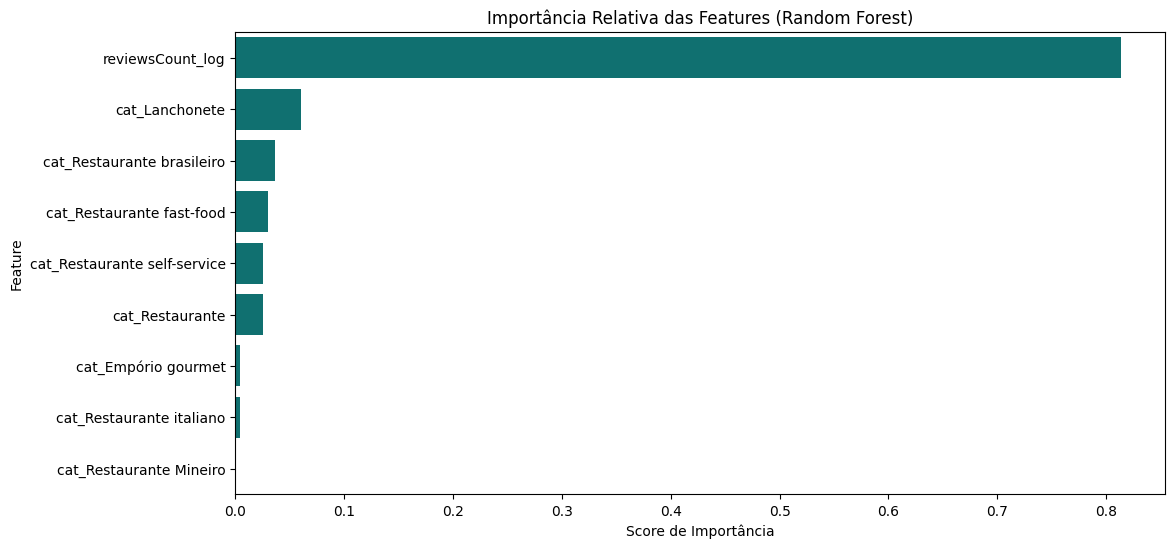

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(best_rf_model.feature_importances_, index=X.columns)

feature_importances_sorted = feature_importances.sort_values(ascending=False)

print("\n=== TOP 10 Features Mais Importantes ===")
print(feature_importances_sorted.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances_sorted.head(10).values, y=feature_importances_sorted.head(10).index, color='teal')
plt.title('Importância Relativa das Features (Random Forest)')
plt.xlabel('Score de Importância')
plt.ylabel('Feature')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

mediana_score = 4.4

df_final['Y_class'] = np.where(df_final['totalScore'] > mediana_score, 1, 0)

print("Nova Variável-Alvo 'Y_class' criada (0=Baixa Nota, 1=Alta Nota).")
print("\nContagem de Classes:")
print(df_final['Y_class'].value_counts())

Y_class = df_final['Y_class']
X_class = df_final.drop(['totalScore', 'Y_class'], axis=1)

from sklearn.model_selection import train_test_split
X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(X_class, Y_class, test_size=0.2, random_state=42, stratify=Y_class)

print(f"\nDivisão para Classificação: {Y_train_c.value_counts()}")

Nova Variável-Alvo 'Y_class' criada (0=Baixa Nota, 1=Alta Nota).

Contagem de Classes:
Y_class
0    30
1    20
Name: count, dtype: int64

Divisão para Classificação: Y_class
0    24
1    16
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_c, Y_train_c)

print("\nModelo de Regressão Logística treinado com sucesso!")

Y_pred_c = log_reg.predict(X_test_c)


Modelo de Regressão Logística treinado com sucesso!


In [ ]:
accuracy = accuracy_score(Y_test_c, Y_pred_c)
print(f"\nAcurácia do Modelo: {accuracy:.4f} (Proporção de acertos totais)")


conf_matrix = confusion_matrix(Y_test_c, Y_pred_c)
print("\nMatriz de Confusão (Dados de Teste):")
print(conf_matrix)


print("\nRelatório de Classificação Detalhado:")
print(classification_report(Y_test_c, Y_pred_c))


Acurácia do Modelo: 0.8000 (Proporção de acertos totais)

Matriz de Confusão (Dados de Teste):
[[6 0]
 [2 2]]

Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn_classifier = KNeighborsClassifier(n_neighbors=5)

knn_classifier.fit(X_train_c, Y_train_c)

print("\nModelo K-Nearest Neighbors (KNN) treinado com sucesso!")

Y_pred_knn = knn_classifier.predict(X_test_c)

accuracy_knn = accuracy_score(Y_test_c, Y_pred_knn)
conf_matrix_knn = confusion_matrix(Y_test_c, Y_pred_knn)

print("\n=== AVALIAÇÃO DO MODELO KNN ===")
print(f"Acurácia do Modelo KNN: {accuracy_knn:.4f}")
print("\nMatriz de Confusão (KNN):")
print(conf_matrix_knn)
print("\nRelatório de Classificação Detalhado (KNN):")
print(classification_report(Y_test_c, Y_pred_knn))


Modelo K-Nearest Neighbors (KNN) treinado com sucesso!

=== AVALIAÇÃO DO MODELO KNN ===
Acurácia do Modelo KNN: 0.5000

Matriz de Confusão (KNN):
[[4 2]
 [3 1]]

Relatório de Classificação Detalhado (KNN):
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.33      0.25      0.29         4

    accuracy                           0.50        10
   macro avg       0.45      0.46      0.45        10
weighted avg       0.48      0.50      0.48        10



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_knn = {
    'n_neighbors': list(range(1, 16, 2)), 
    'weights': ['uniform', 'distance']     
}

grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=5,
    scoring='accuracy', 
    verbose=1,
    n_jobs=-1
)

print("\nIniciando Grid Search para KNN...")
grid_search_knn.fit(X_train_c, Y_train_c)

best_knn_model = grid_search_knn.best_estimator_
Y_pred_tuned_knn = best_knn_model.predict(X_test_c)

accuracy_tuned_knn = accuracy_score(Y_test_c, Y_pred_tuned_knn)

print("\n=== RESULTADOS DA OTIMIZAÇÃO KNN ===")
print("Melhores Parâmetros (K e Weights):", grid_search_knn.best_params_)
print(f"Acurácia do Modelo KNN Otimizado (Teste): {accuracy_tuned_knn:.4f}")
print("\nRelatório de Classificação Detalhado (KNN Otimizado):")
print(classification_report(Y_test_c, Y_pred_tuned_knn))


Iniciando Grid Search para KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

=== RESULTADOS DA OTIMIZAÇÃO KNN ===
Melhores Parâmetros (K e Weights): {'n_neighbors': 5, 'weights': 'uniform'}
Acurácia do Modelo KNN Otimizado (Teste): 0.5000

Relatório de Classificação Detalhado (KNN Otimizado):
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.33      0.25      0.29         4

    accuracy                           0.50        10
   macro avg       0.45      0.46      0.45        10
weighted avg       0.48      0.50      0.48        10




=== AVALIAÇÃO COM CURVA ROC/AUC ===
Área Sob a Curva (AUC): 0.4167


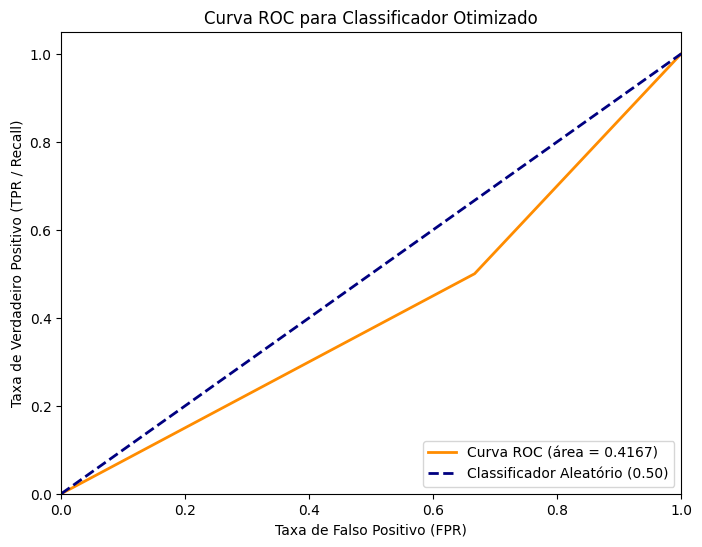

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

best_classifier = best_knn_model  

Y_proba = best_classifier.predict_proba(X_test_c)[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test_c, Y_proba)

roc_auc = auc(fpr, tpr)

print(f"\n=== AVALIAÇÃO COM CURVA ROC/AUC ===")
print(f"Área Sob a Curva (AUC): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador Aleatório (0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR / Recall)')
plt.title('Curva ROC para Classificador Otimizado')
plt.legend(loc="lower right")
plt.show()

In [21]:
import joblib
import os

model_directory = 'models'
os.makedirs(model_directory, exist_ok=True)

classifier_filename = f'{model_directory}/classificador_vencedor_otimizado.pkl'

joblib.dump(best_classifier, classifier_filename)

print(f"\n Classificador Vencedor salvo em: {classifier_filename}")


 Classificador Vencedor salvo em: models/classificador_vencedor_otimizado.pkl


In [25]:
import pandas as pd
import os

processed_dir = 'data/02_processed'
processed_filename = f'{processed_dir}/restaurantes_goiania_processado.csv'

os.makedirs(processed_dir, exist_ok=True)

df_final.to_csv(processed_filename, index=False)

print(f"\nDataset processado salvo em: {processed_filename}")


Dataset processado salvo em: data/02_processed/restaurantes_goiania_processado.csv


In [24]:
import joblib
import os
from sklearn.linear_model import LogisticRegression

model_directory = 'models'
os.makedirs(model_directory, exist_ok=True)

classifier_filename = f'{model_directory}/classificador_alta_baixa_nota.pkl'

joblib.dump(best_classifier, classifier_filename)

print(f"\n Classificador de Alta/Baixa Nota salvo em: {classifier_filename}")


 Classificador de Alta/Baixa Nota salvo em: models/classificador_alta_baixa_nota.pkl
